In [1]:
from skimage.filters import gabor_kernel
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from PIL import Image
import numpy as np

%matplotlib inline

In [2]:
img = np.array(Image.open('./westworld.png'))

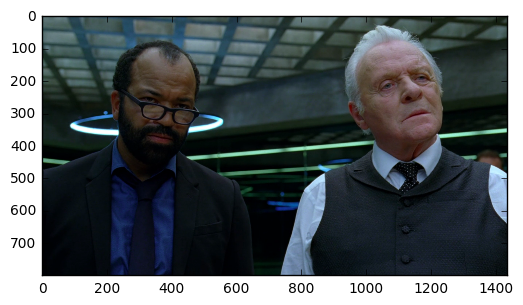

In [3]:
plt.imshow(img);

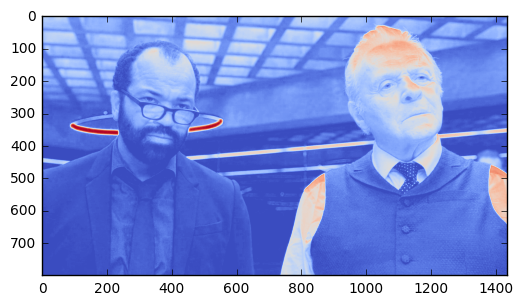

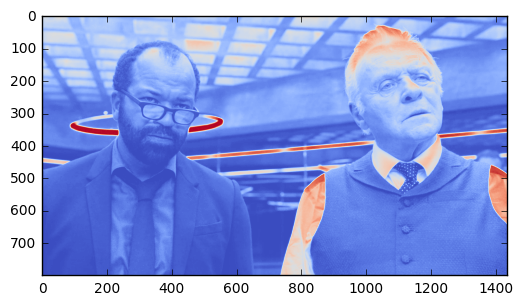

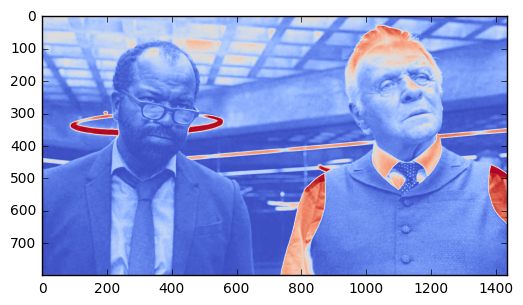

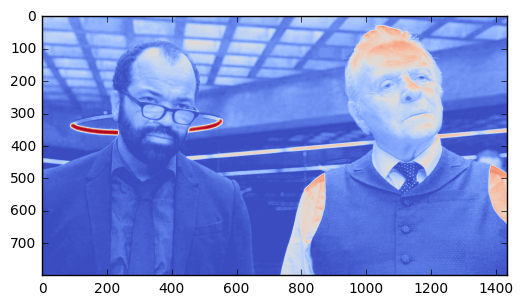

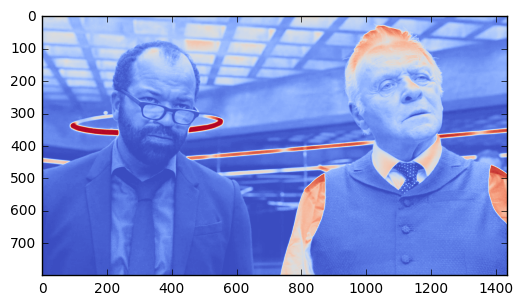

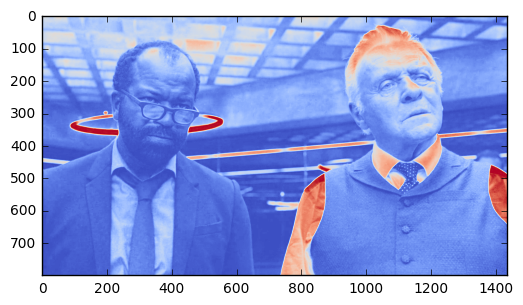

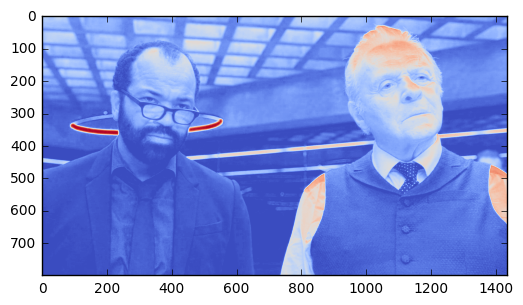

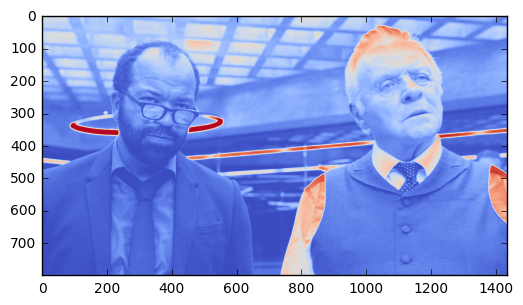

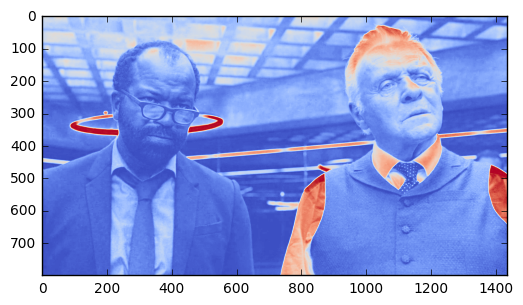

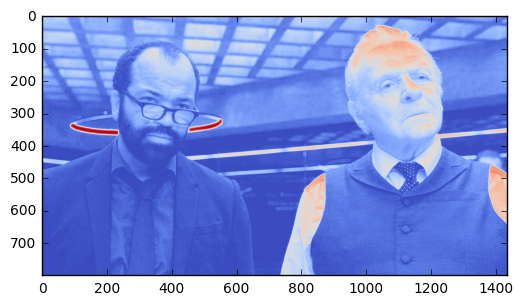

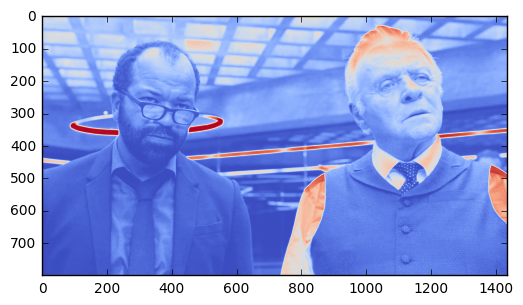

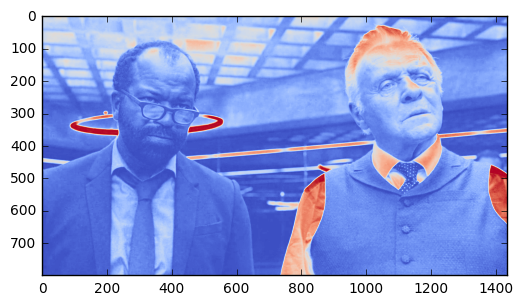

In [4]:
responses = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1,):
        for frequency in (0.05,):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            for channel in range(3):
                response = ndi.convolve(
                    img[:, :, channel],
                    kernel,
                    mode='wrap'
                )
                responses.append(response)
                plt.figure()
                plt.imshow(response, cmap='coolwarm')

In [5]:
responses_tensor = np.dstack(responses)

responses_design = responses_tensor.reshape((-1, responses_tensor.shape[-1]))

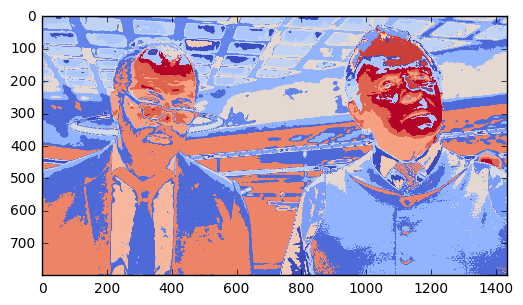

In [6]:
from sklearn.cluster import MiniBatchKMeans

n_clusters=16
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100)
kmeans.fit(responses_design)

blah = kmeans.predict(responses_design)

clustered = blah.reshape(img.shape[:2])

plt.imshow(clustered, cmap='coolwarm')

In [7]:
def min_max_norm(img):
    return (img - img.min()) / (img.max() - img.min())

blurred = ndi.gaussian_filter(img[:,:,1], 8)
sx = ndi.sobel(blurred, axis=0, mode='constant')
sy = ndi.sobel(blurred, axis=1, mode='constant')
sob = np.hypot(sx, sy)
sob = min_max_norm(sob)

In [ ]:
import os
outdir = './output'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

gabor_resp = min_max_norm(responses[-1])
clustered_norm = min_max_norm(clustered)
other_resp = sob * clustered_norm

num = 100
enumerator = enumerate(np.concatenate([np.linspace(0, 1, num/2 + 1), np.linspace(1, 0, num/2-1)]))
for idx, w1 in enumerator:
    w2 = 1. - w1
    res = w1 * gabor_resp + w2 * other_resp
    #plt.figure(figsize=(12, 10))
    #plt.imshow(res, cmap='Spectral')
    plt.imsave(os.path.join(outdir, 'westworld_{}.png'.format(idx)), res, cmap='Spectral')

In [8]:
# Resulting GIF:
# https://gfycat.com/TediousQuarrelsomeIvorybilledwoodpecker